In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [38]:
from utils import QUBO, get_final_ryd_Hamiltonian_v2, show_coords, get_partition_function, find_sic
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import itertools

from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.aws import AwsDevice 
from braket.aws import AwsQuantumTask


# For 2x2 cells with 8 atoms

We scan J1 from -0.01 to -0.1, and found that 
1. At certain positions (6/100), the Rydberg system cannot find the correct answer for the QUBO problem
2. For J1 < -0.022, the only solution is all variables take value '1', and Rydberg system can find the correct answer with correct multiplicity
3. For J1 > -0.02, the Rydberg system can find two out of the six solutions. 


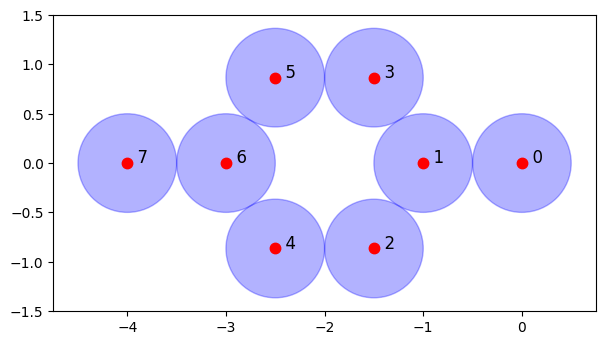

In [17]:
coords = [[0, 0], 
          [0, -1],
          [-np.sqrt(3)/2, -3/2],
          [np.sqrt(3)/2, -3/2],
          [-np.sqrt(3)/2, -5/2],
          [np.sqrt(3)/2, -5/2],
          [0, -3],
          [0, -4],
         ]

neighbors = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (6, 7)
]


coords = [[item[1], item[0]] for item in coords] # Rotate by 90 degrees so that the y-separation is larger than 4 um

show_coords(coords)

In [60]:
def run_adiabatic_program(coords, 
    detuning = 125000000.0,
    J1=0.080403, 
    J2=0.016065, # J2=0.019894, # 
    C6 = 5.42e-24,
    t_max = 4e-6,
    t_ramp = 2.5e-7,
    detuning_min = -5.5e7,
    amplitude_max = 1.57e7,
    device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila"),
    shots = 100,
):
    
    num_atoms = len(coords)
    
    if J1 == 0:
        detuning = 0
#         R = 8e-6
    elif J1 < 0:
        detuning = abs(detuning)
    else:
        detuning = -abs(detuning)
    
    
    
    R = (C6/detuning * -J1/J2)**(1/6)
    ratio = abs(detuning/1e6 / J1)
    
    
    # We will define the Hamiltonian via a ficticious AHS program
    
    # Define the register 
    register = AtomArrangement()

    for coord in coords:
        register.add(np.array(coord) * R)
        
    time_points = [0, t_ramp, t_max-t_ramp, t_max]
    amplitude_values = [0.0, amplitude_max, amplitude_max, 0.0]  # piecewise linear
    detuning_values = [detuning_min, detuning_min, detuning, detuning]  # piecewise linear
    phase_values = [0, 0, 0, 0]  # piecewise constant

    
    drive = DrivingField.from_lists(time_points, amplitude_values, detuning_values, phase_values)
    
    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )
    
    task = device.run(program.discretize(device), shots=shots)
    
    
    return task.metadata()['quantumTaskArn']
    

In [61]:
J1range = [-0.1, -0.06111, -0.02075, -0.015068, -0.01]
task_arns = [run_adiabatic_program(coords, J1=J1, shots=1000) for J1 in J1range]
np.savez("task_arns_2_2", task_arns=task_arns)

In [78]:
results = [AwsQuantumTask(arn=arn).result()
           for arn in np.load("task_arns_2_2.npz", allow_pickle=True)["task_arns"]
          ]
counts = [result.get_counts() for result in results]

In [75]:
for i in range(len(J1range)):
    _, _, _, config_qubo = QUBO(neighbors, J1=J1range[i])
    print([sorted(counts[i].items(), key=lambda x:x[1])[-1], config_qubo])

[('rrrrrrrr', 54), ['11111111']]
[('rrrrrrrr', 66), ['11111111']]
[('rgrrrrgr', 48), ['10111101']]
[('rgrrgrgr', 11), ['01001101', '10001101', '10011001', '10100101', '10110001', '10110010']]
[('rggrrggr', 30), ['01001101', '10001101', '10011001', '10100101', '10110001', '10110010']]
